In [491]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# For saving/loading the model
import joblib

 1. Load the dataset & 2. Quick Exploration

In [492]:

#   1. Replace 'zomato_data.csv' with the actual path to your dataset.
df = pd.read_csv('ZomatoData.csv', encoding='latin1')

# 2.
print("Data Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nSample Rows:")
print(df.head())


Data Shape: (9551, 19)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9551 entries, 0 to 9550
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Restaurant ID         9551 non-null   int64  
 1   Restaurant Name       9551 non-null   object 
 2   Country Code          9551 non-null   int64  
 3   City                  9551 non-null   object 
 4   Address               9551 non-null   object 
 5   Locality              9551 non-null   object 
 6   Locality Verbose      9551 non-null   object 
 7   Longitude             9551 non-null   float64
 8   Latitude              9551 non-null   float64
 9   Cuisines              9542 non-null   object 
 10  Currency              9551 non-null   object 
 11  Has Table booking     9551 non-null   object 
 12  Has Online delivery   9551 non-null   object 
 13  Is delivering now     9551 non-null   object 
 14  Switch to order menu  9551 non-null

3. Data Cleaning

In [493]:
# 3. Data Cleaning
#    3.1 Handle missing values (example: drop rows with missing rating)
df = df.dropna(subset=['Rating'])  # or use fillna for other columns as needed
df['Cuisines'] = df['Cuisines'].fillna("Unknown")
df.reset_index(drop=True, inplace=True)
print("Missing values after cleaning:\n", df.isnull().sum())

Missing values after cleaning:
 Restaurant ID           0
Restaurant Name         0
Country Code            0
City                    0
Address                 0
Locality                0
Locality Verbose        0
Longitude               0
Latitude                0
Cuisines                0
Currency                0
Has Table booking       0
Has Online delivery     0
Is delivering now       0
Switch to order menu    0
Price range             0
Votes                   0
Average Cost for two    0
Rating                  0
dtype: int64


4. Feature Engineering

In [494]:
# ------------------ FEATURE ENGINEERING ------------------

# 1. Convert 'Yes'/'No' columns to 1/0
yes_no_columns = ['Has Table booking', 'Has Online delivery', 'Is delivering now']
for col in yes_no_columns:
    if col in df.columns:
        df[col] = df[col].map({'Yes': 1, 'No': 0})

# 2. Handle missing 'Cuisines' values and create 'Cuisine_Count'
if 'Cuisines' in df.columns:
    df['Cuisines'] = df['Cuisines'].fillna("Unknown")
    df['Cuisine_Count'] = df['Cuisines'].apply(lambda x: len(str(x).split(',')))
else:
    df['Cuisine_Count'] = 0

# 3. Encode categorical columns like 'City' and 'Currency' using one-hot encoding
categorical_cols = ['City', 'Currency']
df = pd.get_dummies(df, columns=[col for col in categorical_cols if col in df.columns], drop_first=True)

# 4. Ensure all numeric columns are properly typed
numeric_cols = [
    'Has Table booking', 'Has Online delivery', 'Is delivering now',
    'Price range', 'Votes', 'Average Cost for two', 'Cuisine_Count', 'Rating'
]

for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# 5. Drop rows with missing numeric data (if any remain)
df = df.dropna(subset=numeric_cols)

# Optional: Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

# ---------------------------------------------------------

'''
# 4. Feature Engineering
#    Example transformations. Adjust these to match your dataset columns.

# 4.1 Convert Yes/No columns to 1/0 if they exist
if 'Has Table booking' in df.columns:
    df['Has Table booking'] = df['Has Table booking'].map({'Yes': 1, 'No': 0})

if 'Has Online delivery' in df.columns:
    df['Has Online delivery'] = df['Has Online delivery'].map({'Yes': 1, 'No': 0})

if 'Is delivering now' in df.columns:
    df['Is delivering now'] = df['Is delivering now'].map({'Yes': 1, 'No': 0})

# 4.2 Create a 'Cuisine_Count' from 'Cuisines' column if it exists
if 'Cuisines' in df.columns:
    df['Cuisine_Count'] = df['Cuisines'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
else:
    df['Cuisine_Count'] = 0  # fallback if no 'Cuisines' column

# 4.3 Ensure numeric columns are properly typed
numeric_cols = [
    'Has Table booking', 'Has Online delivery', 'Is delivering now',
    'Price range', 'Votes', 'Average Cost for two', 'Cuisine', 'Rating'
]
# Only include columns that are in the DataFrame:
numeric_cols = [col for col in numeric_cols if col in df.columns]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing numeric data if necessary
df = df.dropna(subset=numeric_cols)'''


"\n# 4. Feature Engineering\n#    Example transformations. Adjust these to match your dataset columns.\n\n# 4.1 Convert Yes/No columns to 1/0 if they exist\nif 'Has Table booking' in df.columns:\n    df['Has Table booking'] = df['Has Table booking'].map({'Yes': 1, 'No': 0})\n\nif 'Has Online delivery' in df.columns:\n    df['Has Online delivery'] = df['Has Online delivery'].map({'Yes': 1, 'No': 0})\n\nif 'Is delivering now' in df.columns:\n    df['Is delivering now'] = df['Is delivering now'].map({'Yes': 1, 'No': 0})\n\n# 4.2 Create a 'Cuisine_Count' from 'Cuisines' column if it exists\nif 'Cuisines' in df.columns:\n    df['Cuisine_Count'] = df['Cuisines'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)\nelse:\n    df['Cuisine_Count'] = 0  # fallback if no 'Cuisines' column\n\n# 4.3 Ensure numeric columns are properly typed\nnumeric_cols = [\n    'Has Table booking', 'Has Online delivery', 'Is delivering now',\n    'Price range', 'Votes', 'Average Cost for two', 'Cuisin

5. Exploratory Data Analysis

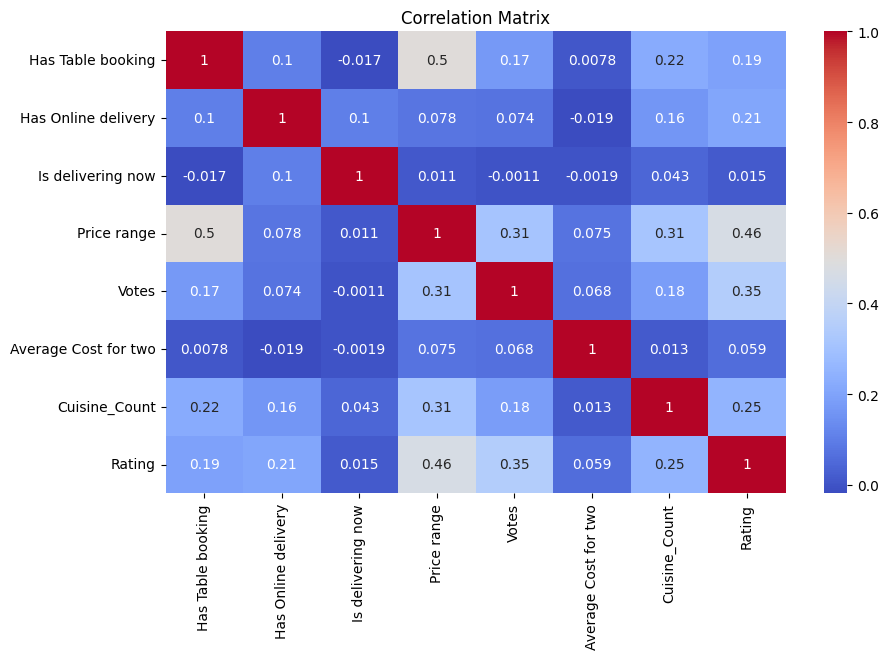

In [495]:
# 5. Exploratory Data Analysis
#    Quick correlation heatmap (adjust size as needed)
plt.figure(figsize=(10, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [496]:
# Example feature engineering for cuisines
if 'Cuisines' in df.columns:
    # Create a numeric column that counts the number of cuisines
    df['Cuisine_Count'] = df['Cuisines'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)
    # Optionally, drop the original 'Cuisines' column if not needed
    df.drop('Cuisines', axis=1, inplace=True)

# Define the feature columns
feature_cols = [
    'Has Table booking',
    'Has Online delivery',
    'Is delivering now',
    'Price range',
    'Votes',
    'Average Cost for two',
    'Cuisine_Count' 
]

# Check if any feature column is missing
missing_features = [col for col in feature_cols if col not in df.columns]
if missing_features:
    print("Missing columns in the DataFrame:", missing_features)
    # Optionally, adjust feature_cols or handle the missing columns

# Now split your data into features and target
X = df[feature_cols]
y = df['Rating']

# Proceed with your train-test split and model training as usual
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=32
)

from sklearn.ensemble import RandomForestRegressor

# Create a more optimized Random Forest model
rf_reg = RandomForestRegressor(
    n_estimators=200,         # Number of trees (Uses 200 trees instead of the default 100	Usually improves accuracy more trees = better but slightly slower)
    max_depth=10,             # Limits how deep each tree can go (prevents overfitting won’t grow deeper than 10 levels)
    min_samples_split=5,      # Minimum number of samples to split an internal node
    min_samples_leaf=3,       # Minimum number of samples at a leaf node
    max_features='sqrt',      # Number of features to consider when looking for the best split
    random_state=32,          # Ensures reproducibility
    n_jobs=-1                 # Use all CPU cores to train faster
)

# Train the model
rf_reg.fit(X_train, y_train)

'''rf_reg = RandomForestRegressor(random_state=32)
rf_reg.fit(X_train, y_train)'''


'rf_reg = RandomForestRegressor(random_state=32)\nrf_reg.fit(X_train, y_train)'

9. Model Evaluation

In [497]:
# 9. Model Evaluation
y_pred = rf_reg.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance on Test Set:")

#print(f"RMSE: {(rmse) * 100:.2f} %")
print(f"RMSE: {rmse:.4f}")
print(f"R^2 Score: {(r2) * 100:.2f} %")


Model Performance on Test Set:
RMSE: 0.3358
R^2 Score: 91.34 %


In [498]:
# 10. Feature Importances (Optional, for Random Forest)
importances = rf_reg.feature_importances_
for name, val in zip(feature_cols, importances):
    print(f"Feature: {name}, Importance: {val:.4f}")

Feature: Has Table booking, Importance: 0.0073
Feature: Has Online delivery, Importance: 0.0169
Feature: Is delivering now, Importance: 0.0002
Feature: Price range, Importance: 0.0889
Feature: Votes, Importance: 0.8009
Feature: Average Cost for two, Importance: 0.0703
Feature: Cuisine_Count, Importance: 0.0155


In [499]:
model_filename = "restaurant_rating_model.pkl"
joblib.dump(rf_reg, model_filename)
print(f"\nModel saved to: {model_filename}")


Model saved to: restaurant_rating_model.pkl


In [500]:

modelfile = "restaurant_rating_model.pkl"
model = joblib.load(modelfile)

def predict(has_table_booking, has_online_delivery, is_delivering_now, price_range, votes, average_cost_for_two, cuisine_count):
    table_booking = 1 if has_table_booking.lower() == "yes" else 0
    online_delivery = 1 if has_online_delivery.lower() == "yes" else 0
    delivering_now = 1 if is_delivering_now.lower() == "yes" else 0
    data = {
        'Has Table booking': [table_booking],
        'Has Online delivery': [online_delivery],
        'Is delivering now': [delivering_now],
        'Price range': [price_range],
        'Votes': [votes],
        'Average Cost for two': [average_cost_for_two],
        'Cuisine_Count': [cuisine_count]
    }
    
    df = pd.DataFrame(data)
    predicted_rating = model.predict(df)[0]
    threshold = 3.8
    performance = "Perform" if predicted_rating >= threshold else "Not Perform"
    
    return predicted_rating, performance

sample_restaurant = {
    "has_table_booking": "yes",
    "has_online_delivery": "no",
    "is_delivering_now": "yes",
    "price_range": 5,
    "votes": 20,
    "average_cost_for_two": 700,
    "cuisine_count": 5
}

rating, result = predict(**sample_restaurant)
print("Predicted Rating:", rating)
print("Restaurant Performance:", result)


Predicted Rating: 3.4324121701049397
Restaurant Performance: Not Perform
